In [1]:
#!pip install datasets
from datasets import load_dataset

#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
from sklearn.metrics import auc, roc_curve, precision_score, recall_score, precision_recall_curve

import numpy as np

/Users/pavone/.venv/fair/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [2]:
ds = load_dataset("criteo/FairJob")
df = ds['train'].to_pandas()

In [9]:
def print_results(X_test, y_test, model):
    # Calcul des probabilités des prédictions
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilité d'être classe 1

    # Calcul des courbes précision-rappel
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Calcul du F1-score pour chaque seuil
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Évite division par zéro

    # Trouver l'index du meilleur F1-score
    best_threshold_index = np.argmax(f1_scores)

    # Le tableau "thresholds" est plus court d'un élément → il faut ajuster l'indexation
    if best_threshold_index == 0:  # Si le max est au début, on prend le premier seuil
        best_threshold = thresholds[0]
    else:
        best_threshold = thresholds[best_threshold_index - 1]

    # Précision et rappel au meilleur seuil
    precision_optimal = precisions[best_threshold_index]
    recall_optimal = recalls[best_threshold_index]
    f1_score_optimal = f1_scores[best_threshold_index]

    print(f'Best Threshold: {best_threshold}')
    print(f'\nPrecision at Best Threshold: {precision_optimal}')
    print(f'Recall at Best Threshold: {recall_optimal}')
    print(f'f1_score at Best Threshold: {f1_score_optimal}')



    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[1:], label='Précision', color='blue')
    plt.plot(thresholds, recalls[1:], label='Recall', color='red')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label="Seuil Optimal")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.title("Courbe Précision-Recall en fonction du seuil")
    plt.legend()
    plt.grid()
    plt.show()


In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['click','user_id','impression_id','product_id'])
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### XGBoost sans sampling

entraînement de XGBoost fini
Best Threshold: 0.11490745097398758

Precision at Best Threshold: 0.06493212669683258
Recall at Best Threshold: 0.19158878504672897
f1_score at Best Threshold: 0.09699222672564475


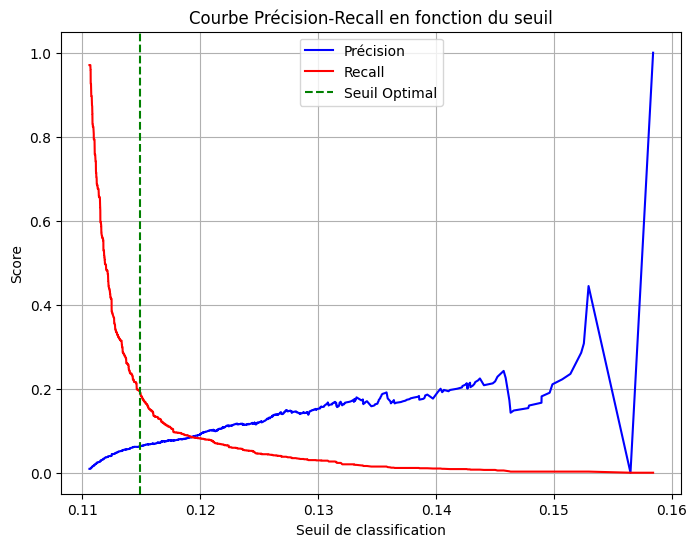

In [11]:
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, f1_score

xgb_model = XGBClassifier(
    n_estimators=100, max_depth=10, learning_rate=0.001, 
    random_state=42, eval_metric='logloss')

xgb_model.fit(X_train,y_train)
print('entraînement de XGBoost fini')

print_results(X_test, y_test, xgb_model)


Problems:
- No tuning of hyperparameters
- No encoding of categorical features
- How to treat _id columns? Maybe to exclude?
- F1 score perhaps not optimal with unbalanced classes

In [12]:
X_train

,protected_attribute,senior,displayrandom,rank,cat0,cat1,cat2,cat3,cat4,cat5,...,num41,num42,num43,num44,num45,num46,num47,num48,num49,num50
880150,1,1,0,6,6,8,163,14,54,0,...,1.645154,6.797939,-0.393358,0.097485,-0.494652,0.142872,6.112543,-0.577173,-0.264359,0.195645
161321,0,0,0,1,5,5,132,38,2,910,...,-0.333033,-0.542801,-0.393358,-0.887341,0.027636,-0.354176,-0.345480,-0.577173,-0.264359,-0.840959
592878,1,1,0,3,5,8,733,73,25,1243,...,-0.333033,-0.542801,-0.386944,-0.235002,-0.088428,-0.524096,-0.160055,-0.577173,-0.264359,-0.115336
692089,0,1,0,7,8,8,966,73,34,1243,...,-0.050435,0.925347,-0.329216,-0.339181,-0.032604,-0.441723,0.359545,-0.577173,-0.264359,-0.270827
186556,1,0,0,2,7,7,945,73,104,1288,...,-0.333033,-0.542801,1.123620,-0.063114,-0.436620,-0.465891,-0.345480,-0.122965,-0.264359,-0.011676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010828,0,1,0,8,8,8,644,30,25,1243,...,-0.333033,-0.542801,-0.393358,-0.597837,-0.378588,-0.535856,-0.345480,0.257664,-0.264359,-0.581808
959227,0,1,1,12,6,6,622,3,108,1243,...,0.514761,0.925347,-0.367701,1.110388,-0.513614,0.058326,0.952494,-0.058801,-0.264359,1.180420
548761,1,1,0,11,8,8,721,46,37,977,...,-0.333033,-0.542801,-0.393358,2.424535,-0.494652,0.631364,-0.345480,-0.577173,-0.264359,2.579836
63584,1,1,0,2,7,7,237,24,112,1243,...,-0.333033,-0.542801,-0.069437,0.674238,0.056652,-0.182223,-0.252768,-0.577173,-0.264359,0.817608


In [37]:
import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss


xgb_tree_method = "hist"

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])


In [ ]:
def objective(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)
    
    # scale_pos_weight = (
    #     (np.sum(y_train_train < 1) / np.sum(y_train_train > 0))
    # )
    scale_pos_weight = 1
    
    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }
    
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)
    ## Give more weight to label 1 in the hyper-tuning utility
    scale_pos_weight_val_loss = (
        (np.sum(y_train_train < 1) / np.sum(y_train_train > 0))
    ) # Try to play with this value to focus more on positive labels
    sample_weight = np.ones_like(y_val)
    sample_weight[y_val==1] = scale_pos_weight_val_loss
    
    return log_loss(y_val, prob_val, sample_weight=sample_weight)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal = study.best_trial


[I 2025-03-25 18:56:52,291] A new study created in memory with name: no-name-eb326276-41e8-4b9b-ac3a-9646edd29f8b
[I 2025-03-25 18:56:57,174] Trial 0 finished with value: 1.7866571096998392 and parameters: {'max_depth': 10, 'min_child_weight': 0.08685681675826691, 'subsample': 0.9743076504447974, 'learning_rate': 0.04588618815797902, 'colsample_bytree': 0.7868556190829212, 'reg_lambda': 0.13866204641023816, 'gamma': 0.01274826622266469, 'base_score': 0.8185330636560008}. Best is trial 0 with value: 1.7866571096998392.
[I 2025-03-25 18:57:00,704] Trial 1 finished with value: 1.9650437173764255 and parameters: {'max_depth': 6, 'min_child_weight': 0.49235119211749556, 'subsample': 0.745102494689617, 'learning_rate': 0.037185302746402235, 'colsample_bytree': 0.7547496187471922, 'reg_lambda': 6.352077239205391, 'gamma': 2.139017689346164, 'base_score': 0.04732880716677492}. Best is trial 0 with value: 1.7866571096998392.
[I 2025-03-25 18:57:04,258] Trial 2 finished with value: 2.28684926994

In [45]:
optimal.params

{'max_depth': 8,
 'min_child_weight': 0.747719335949453,
 'subsample': 0.8792294157815488,
 'learning_rate': 0.007400966315483861,
 'colsample_bytree': 0.5000010473967386,
 'reg_lambda': 1.2048582650002366,
 'gamma': 8.584822329750473,
 'base_score': 0.9925859109064453}

In [46]:

# scale_pos_weight = (
#         (np.sum(y_train < 1) / np.sum(y_train > 0))
#     )
scale_pos_weight = 1

xgb_tuned_params = {
    'xgb__max_depth': optimal.params["max_depth"],
    'xgb__min_child_weight': optimal.params["min_child_weight"],
    'xgb__gamma': optimal.params["gamma"],
    'xgb__subsample': optimal.params["subsample"],
    'xgb__learning_rate': optimal.params["learning_rate"],
    'xgb__colsample_bytree': optimal.params["colsample_bytree"],
    'xgb__reg_lambda': optimal.params["reg_lambda"],
    'xgb__base_score': optimal.params["base_score"],
    'xgb__scale_pos_weight': scale_pos_weight,
}
    
xgb_pipe.set_params(**xgb_tuned_params)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('multicat_encoding',
                                                  TargetEncoder(target_type='binary'),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9', 'cat10', 'cat11',
                                                   'cat12'])])),
                ('xgb',
                 XGBClassifier(base_score=0.9925859109064453, booster=None,
                               callbacks...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.007400966315483861, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None,
                               min_child_weight=0.747719335949453, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
print('base: ' + str(log_loss(y_test, xgb_model.predict_proba(X_test))))
print('tuned: ' + str(log_loss(y_test, xgb_pipe.predict_proba(X_test))))

# log loss divided for true label 1 or 0 
print(
    "base on label 1: "
    + str(
        log_loss(
            y_test[y_test == 1], 
            xgb_model.predict_proba(X_test)[y_test == 1, :], 
            labels=[0, 1]
        )
    )
)
print(
    "tuned on label 1: "
    + str(
        log_loss(
            y_test[y_test == 1],
            xgb_pipe.predict_proba(X_test)[y_test == 1, :],
            labels=[0, 1],
        )
    )
)
print(
    "avg prob of 1 on label 1: "
    + str(
        xgb_pipe.predict_proba(X_test)[y_test == 1, 1].mean()
    )
)

print(
    "base on label 0: "
    + str(
        log_loss(
            y_test[y_test == 0], xgb_model.predict_proba(X_test)[y_test == 0, :], 
            labels=[0, 1]
        )
    )
)
print(
    "tuned on label 0: "
    + str(
        log_loss(
            y_test[y_test == 0],
            xgb_pipe.predict_proba(X_test)[y_test == 0, :],
            labels=[0, 1],
        )
    )
)

base: 0.13223286931562603
tuned: 0.6334353507805813
base on label 1: 2.1743444941891203
tuned on label 1: 0.7455785593535641
base on label 0: 0.1178674692458414
tuned on label 0: 0.6326464702724651


Tuned XGB is better in predicting label 0, but worse label 1.

TODO:
- check calibration of probabilities
- tune threshold according to utility

Best Threshold: 0.49290168285369873

Precision at Best Threshold: 0.0463898916967509
Recall at Best Threshold: 0.17156208277703605
f1_score at Best Threshold: 0.07303211106019925


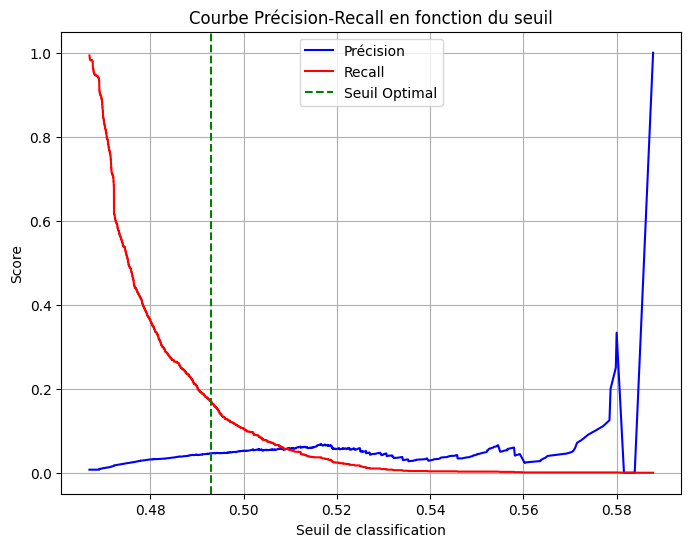

In [48]:
print_results(X_test, y_test, xgb_pipe['xgb'])

## XGBoost avec Oversampling

entraînement de XGBoost fini
Best Threshold: 0.8788126111030579

Precision at Best Threshold: 0.09614010007147963
Recall at Best Threshold: 0.1795727636849132
f1_score at Best Threshold: 0.12523277421990098


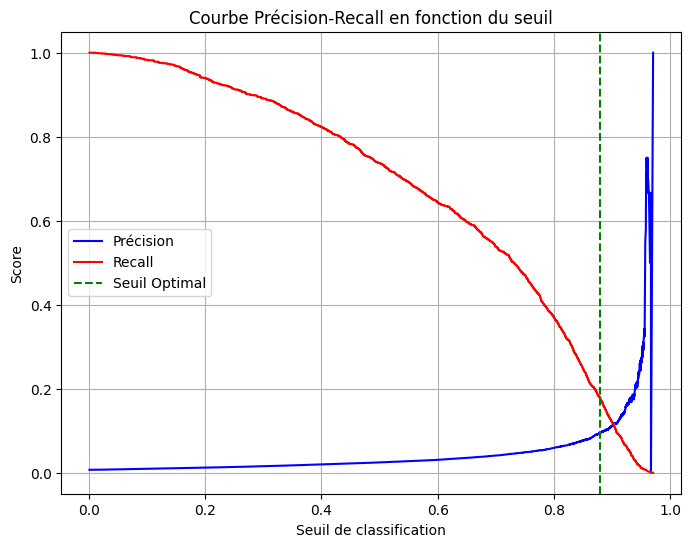

In [46]:
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, f1_score

rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

#print(y_train.value_counts())
#rint(y_res.value_counts())

xgb_model = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.1, 
    random_state=42, eval_metric='logloss')

xgb_model.fit(X_res,y_res)
print('entraînement de XGBoost fini')

print_results(X_test, y_test, xgb_model)

## XGBoost avec poids

entraînement de XGBoost fini
Best Threshold: 0.8713493943214417

Precision at Best Threshold: 0.0882440035534498
Recall at Best Threshold: 0.19893190921228304
f1_score at Best Threshold: 0.12225640983069067


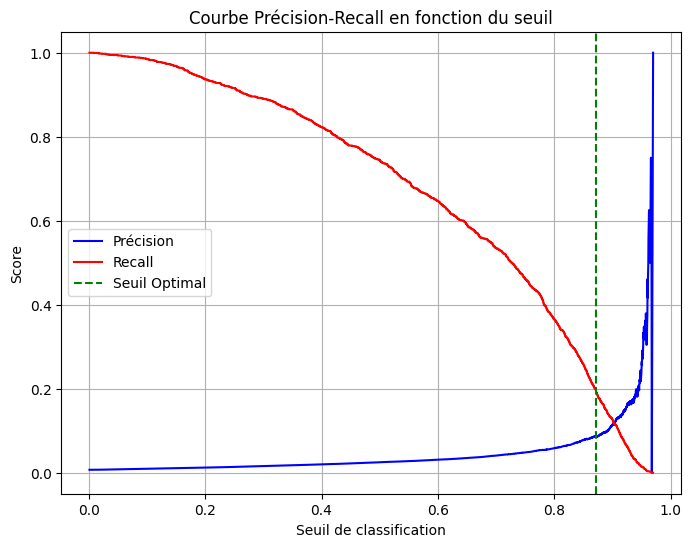

In [47]:
import xgboost as xgb

# Calcul de scale_pos_weight
n_majority = sum(y_train == 0)  # Classe majoritaire (0)
n_minority = sum(y_train == 1)  # Classe minoritaire (1)
scale_pos_weight = n_majority / n_minority

# Initialisation du modèle
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
    random_state=42, scale_pos_weight=scale_pos_weight, eval_metric="logloss")

# Entraînement du modèle
xgb_clf.fit(X_train, y_train)

print('entraînement de XGBoost fini')

print_results(X_test, y_test, xgb_clf)